In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!pip install datasets

In [58]:
from datasets import get_dataset_config_names
tasks = get_dataset_config_names("nguha/legalbench")
print(tasks)

['abercrombie', 'canada_tax_court_outcomes', 'citation_prediction_classification', 'citation_prediction_open', 'consumer_contracts_qa', 'contract_nli_confidentiality_of_agreement', 'contract_nli_explicit_identification', 'contract_nli_inclusion_of_verbally_conveyed_information', 'contract_nli_limited_use', 'contract_nli_no_licensing', 'contract_nli_notice_on_compelled_disclosure', 'contract_nli_permissible_acquirement_of_similar_information', 'contract_nli_permissible_copy', 'contract_nli_permissible_development_of_similar_information', 'contract_nli_permissible_post-agreement_possession', 'contract_nli_return_of_confidential_information', 'contract_nli_sharing_with_employees', 'contract_nli_sharing_with_third-parties', 'contract_nli_survival_of_obligations', 'contract_qa', 'corporate_lobbying', 'cuad_affiliate_license-licensee', 'cuad_affiliate_license-licensor', 'cuad_anti-assignment', 'cuad_audit_rights', 'cuad_cap_on_liability', 'cuad_change_of_control', 'cuad_competitive_restricti

In [60]:
from datasets import load_dataset
import pandas as pd

# [, 'contract_nli_confidentiality_of_agreement',
task_list = [
    'cuad_cap_on_liability',
    'cuad_audit_rights',
    'cuad_insurance'
]


all_dfs = []

for task in task_list:
    data = load_dataset("nguha/legalbench", task, trust_remote_code=True)
    df = pd.DataFrame(data['test'])  # or 'test'
    df['cleaned_text'] = df['text'].str.lower().str.strip()
    df['label'] = df['answer'].apply(lambda x: 1 if x.lower() == 'yes' else 0)
    df['task'] = task  # Optional: track which task it came from
    all_dfs.append(df[['cleaned_text', 'label', 'task']])

big_df = pd.concat(all_dfs, ignore_index=True)
print(f"Combined dataset size: {len(big_df)} samples")


Combined dataset size: 3492 samples


In [61]:
big_df

,cleaned_text,label,task
0,notwithstanding anything contained in this agr...,1,cuad_cap_on_liability
1,notwithstanding anything to the contrary in th...,1,cuad_cap_on_liability
2,"neither lbio nor md anderson, nor any of their...",1,cuad_cap_on_liability
3,ncc shall in no circumstances be liable to the...,1,cuad_cap_on_liability
4,the investor acknowledges and agrees that if a...,1,cuad_cap_on_liability
...,...,...,...
3487,during the term of this agreement nvos shall h...,0,cuad_insurance
3488,exact shall use commercially reasonable effort...,0,cuad_insurance
3489,once you have units open and operating in the ...,0,cuad_insurance
3490,"all such products, services, concepts, methods...",0,cuad_insurance


In [62]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    big_df['cleaned_text'], big_df['label'],
    test_size=0.2,
    stratify=big_df['label'],
    random_state=42
)

print(f'Training set size: {len(X_train)}, Test set size: {len(X_test)}')


Training set size: 2793, Test set size: 699


In [63]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train SVM model
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = svm.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall   : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')


Model Evaluation:
Accuracy : 0.8770
Precision: 0.8525
Recall   : 0.9112
F1 Score : 0.8809


In [64]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))


Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.84      0.87       350
         Yes       0.85      0.91      0.88       349

    accuracy                           0.88       699
   macro avg       0.88      0.88      0.88       699
weighted avg       0.88      0.88      0.88       699



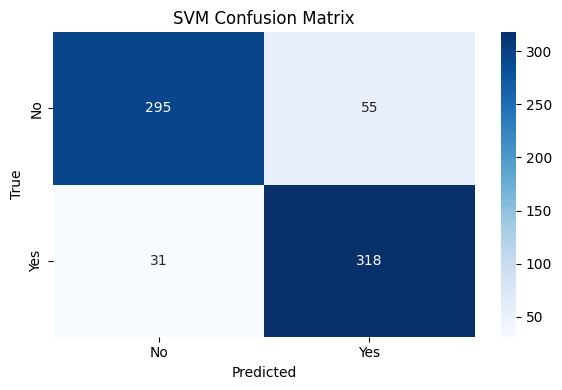

In [65]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [66]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm, vectorizer.transform(df['cleaned_text']), df['label'], cv=5)
print("CV Accuracy:", scores.mean())

CV Accuracy: 0.9825242718446603
